# Energy Demand Data Exploratory Analysis

This notebook performs exploratory data analysis (EDA) on the processed energy demand data for the Italian energy market from 2015-2024. It includes:
- Time series decomposition
- Stationarity tests
- Autocorrelation analysis
- Feature engineering
- Visualization generation
- Train/test split preparation

The analysis helps understand patterns in energy demand and prepares data for forecasting models.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## Setup

Configure plotting style and define paths for data and output files.

In [32]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths for notebook environment
NOTEBOOK_DIR = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parent  # Go up one level from notebooks/ to project root
DATA_DIR = BASE_DIR / 'data/final/Italy'
IMAGES_DIR = BASE_DIR / 'outputs/images'
PROCESSED_DIR = BASE_DIR / 'data/processed/Italy'

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Images directory: {IMAGES_DIR}")

Base directory: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project
Data directory: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy
Images directory: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/outputs/images


In [33]:
# Create directories if they don't exist
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

## Data Loading

Load the processed energy demand data from CSV file.

In [34]:
def load_data():
    """Load the processed demand data"""
    print("Loading demand data...")
    file_path = DATA_DIR / 'energy_demand2015_2024_merged.csv'
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Rename column for consistency
    df.rename(columns={'demand_mw': 'Demand'}, inplace=True)
    
    print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [35]:
# Load the data
df = load_data()

Loading demand data...
Data loaded: 3653 rows, 6 columns


## Basic Statistics

Examine the basic statistics of the demand data, check for missing values, and view the first few rows.

In [36]:
def display_basic_stats(df):
    """Display basic statistics of the data"""
    print("\nBasic Statistics:")
    print(df.describe())
    
    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.any() > 0 else "No missing values")
    
    print("\nFirst few rows:")
    print(df.head())

In [37]:
# Display basic statistics
display_basic_stats(df)


Basic Statistics:
             Demand         year        month          day  price_eur_mwh
count   3653.000000  3653.000000  3653.000000  3653.000000    3653.000000
mean   32606.911462  2019.500411     6.522310    15.731454      96.647910
std     4781.024339     2.873056     3.449345     8.802064      90.098071
min    18905.625000  2015.000000     1.000000     1.000000      10.659308
25%    29000.500000  2017.000000     4.000000     8.000000      47.397251
50%    33394.166667  2020.000000     7.000000    16.000000      60.367120
75%    36052.583333  2022.000000    10.000000    23.000000     112.136641
max    46431.541667  2024.000000    12.000000    31.000000     740.091314

Missing Values:
No missing values

First few rows:
                  Demand  is_outlier  year  month  day  price_eur_mwh
date                                                                 
2015-01-01  24518.208333       False  2015      1    1      45.472115
2015-01-02  28477.583333       False  2015      1    

## Time Series Analysis

Analyze the time series properties of the demand data, including seasonal decomposition and stationarity tests.

In [38]:
def time_series_analysis(df):
    """Perform time series analysis"""
    print("\nPerforming time series analysis...")
    
    # Resample to monthly for better visualization
    monthly_demand = df['Demand'].resample('M').mean()
    
    # Plot time series
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Demand'], linewidth=1, alpha=0.7, label='Daily Demand')
    plt.plot(monthly_demand.index, monthly_demand, linewidth=2, color='red', label='Monthly Average Demand')
    plt.title('Energy Demand Time Series (2015-2024)')
    plt.ylabel('Demand (MWh)')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()
    plt.savefig(IMAGES_DIR / 'demand_time_series.png', bbox_inches='tight')
    plt.show()
    


Performing time series analysis...


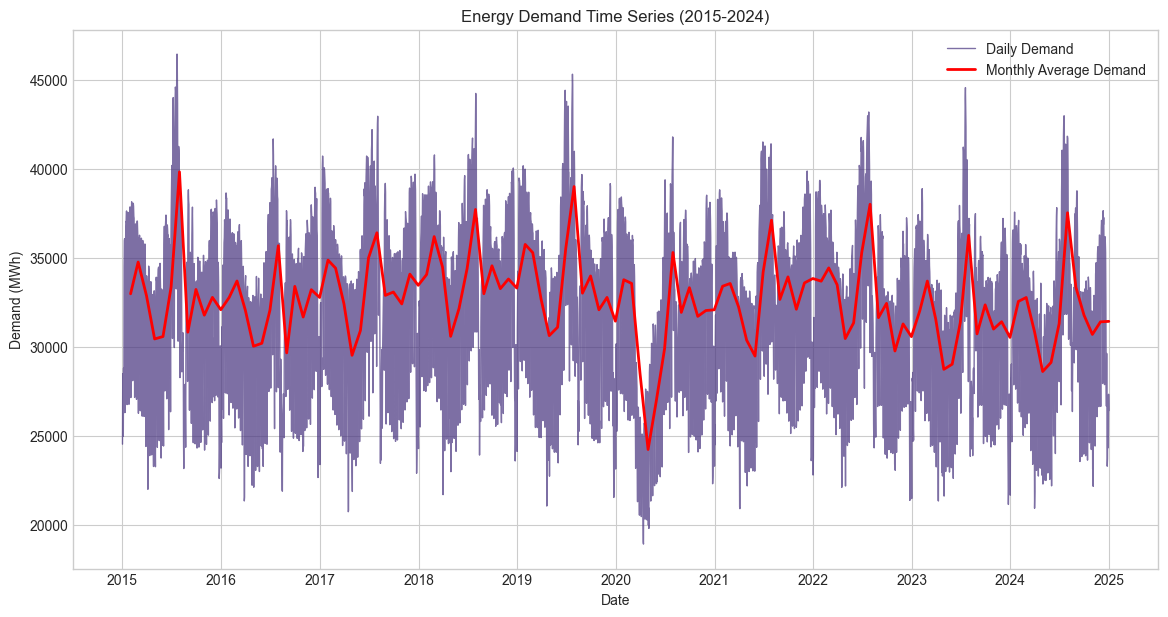

In [39]:
# Perform time series analysis
time_series_analysis(df)

## Correlation Analysis

Analyze correlations between demand and time-based features, and examine monthly and daily patterns.

In [40]:
def correlation_analysis(df):
    """Perform correlation analysis"""
    print("\nPerforming correlation analysis...")
    
    # Create time-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    # Calculate correlation between demand and time features
    time_features = ['year', 'month', 'day', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear']
    correlations = df[time_features + ['Demand']].corr()['Demand'].drop('Demand')
    
    # Plot correlation
    plt.figure(figsize=(12, 6))
    correlations.sort_values().plot(kind='bar')
    plt.title('Correlation of Time Features with Energy Demand')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'demand_time_correlation.png', bbox_inches='tight')
   
    
    # Monthly and daily patterns
    monthly_avg = df.groupby('month')['Demand'].mean()
    daily_avg = df.groupby('dayofweek')['Demand'].mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    monthly_avg.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Average Demand by Month')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Average Demand (MWh)')
    axes[0].grid(True)
    
    daily_avg.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Average Demand by Day of Week')
    axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    axes[1].set_ylabel('Average Demand (MWh)')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'demand_patterns.png', bbox_inches='tight')
    
    
    return df


Performing correlation analysis...


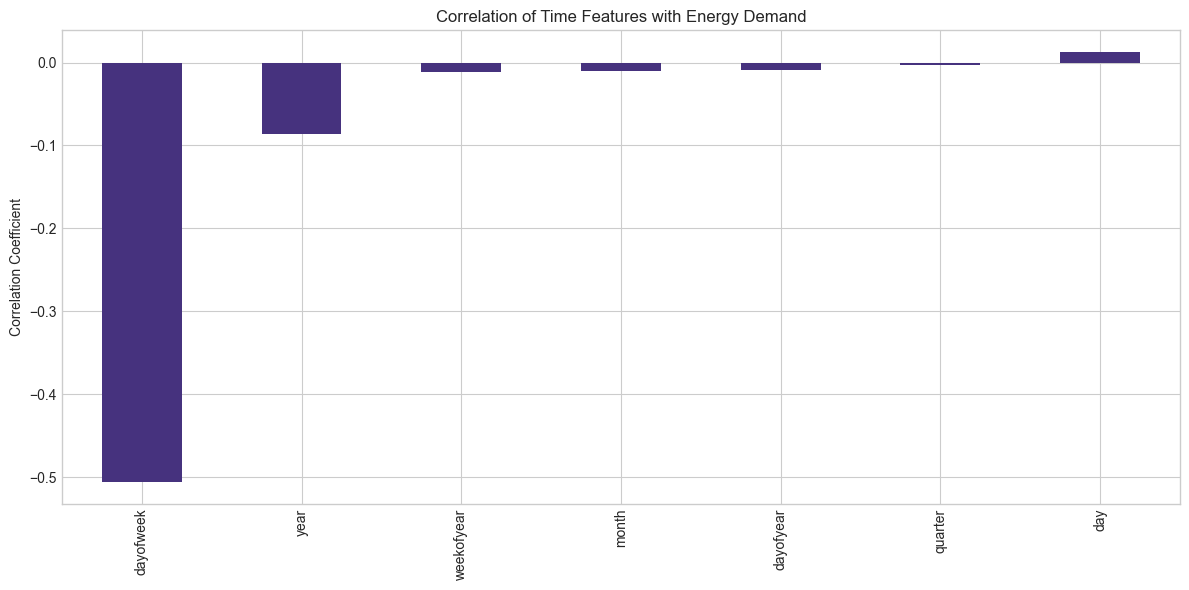

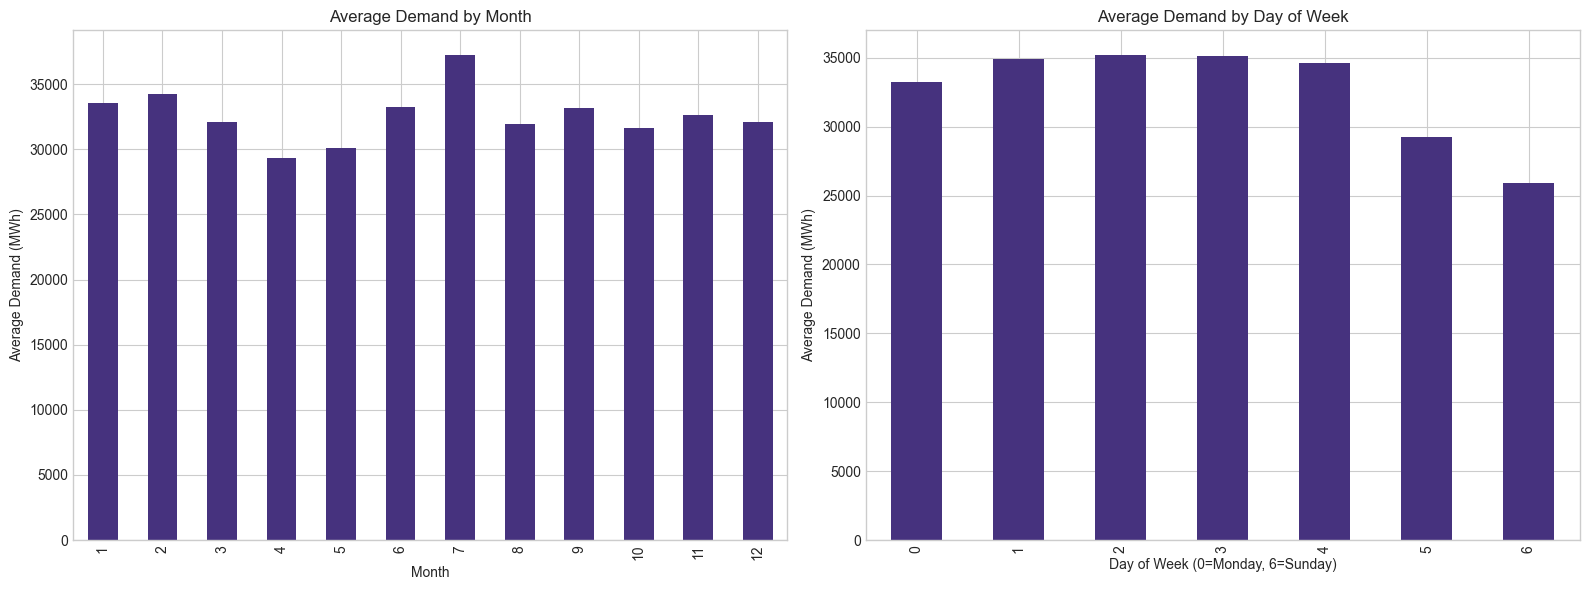

In [41]:
# Perform correlation analysis
df = correlation_analysis(df)

## Feature Engineering

Create additional features for modeling, including lag features, rolling statistics, and year-over-year comparisons.

In [42]:
def feature_engineering(df):
    """Create features for modeling"""
    print("\nPerforming feature engineering...")
    
    # Create lag features
    df['demand_lag1'] = df['Demand'].shift(1)
    df['demand_lag7'] = df['Demand'].shift(7)
    df['demand_lag30'] = df['Demand'].shift(30)
    
    # Create rolling window features
    df['demand_rolling_7d_mean'] = df['Demand'].rolling(window=7).mean()
    df['demand_rolling_30d_mean'] = df['Demand'].rolling(window=30).mean()
    df['demand_rolling_7d_std'] = df['Demand'].rolling(window=7).std()
    df['demand_rolling_30d_std'] = df['Demand'].rolling(window=30).std()
    
    # Create year-over-year features
    df['demand_yoy_diff'] = df['Demand'] - df['Demand'].shift(365)
    df['demand_yoy_ratio'] = df['Demand'] / df['Demand'].shift(365)
    
    # Plot some of the engineered features
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[-365:], df['Demand'][-365:], label='Demand')
    plt.plot(df.index[-365:], df['demand_rolling_7d_mean'][-365:], label='7-day MA')
    plt.plot(df.index[-365:], df['demand_rolling_30d_mean'][-365:], label='30-day MA')
    plt.title('Demand and Rolling Averages (Last Year)')
    plt.ylabel('Demand (MWh)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.savefig(IMAGES_DIR / 'demand_rolling_features.png', bbox_inches='tight')
    
    # Correlation matrix of engineered features
    feature_cols = ['Demand', 'demand_lag1', 'demand_lag7', 'demand_lag30', 
                   'demand_rolling_7d_mean', 'demand_rolling_30d_mean',
                   'demand_rolling_7d_std', 'demand_rolling_30d_std']
    
    corr_matrix = df[feature_cols].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Engineered Features')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'demand_feature_correlation.png', bbox_inches='tight')
    
    return df


Performing feature engineering...


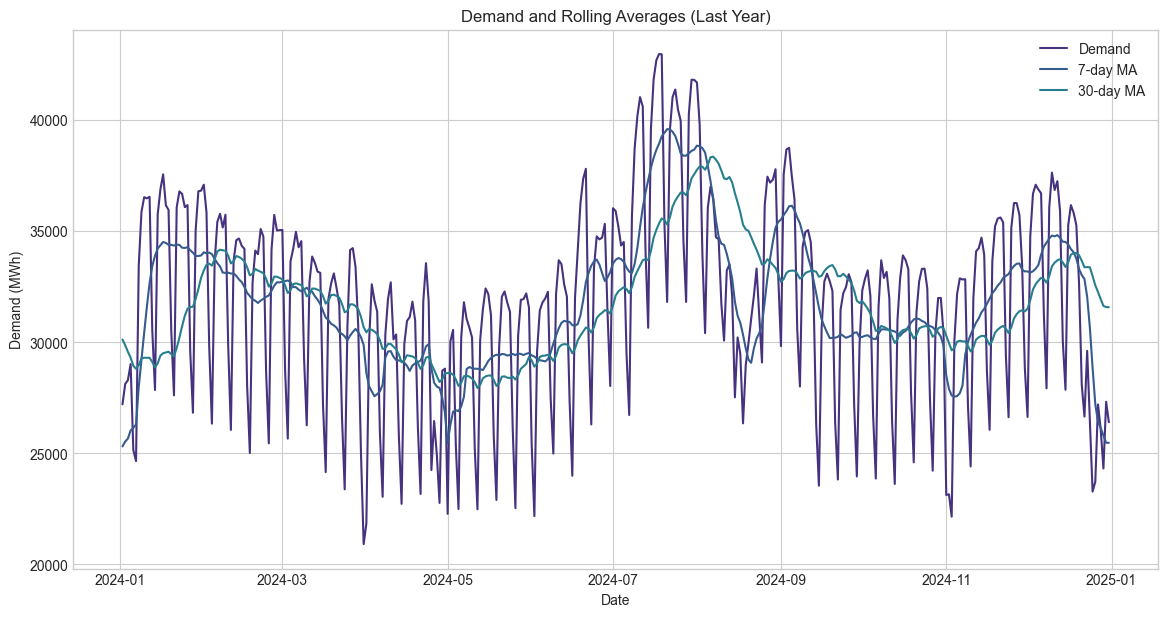

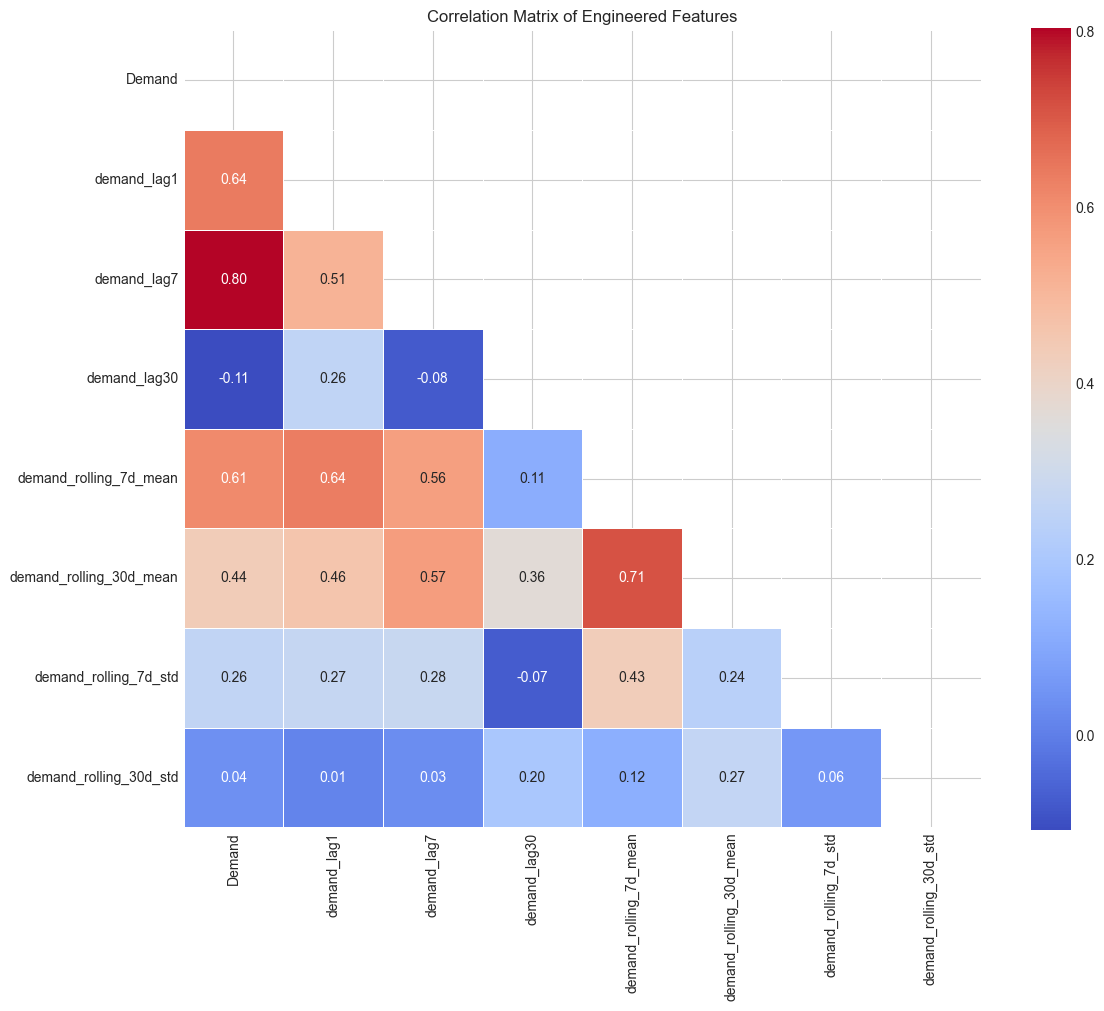

In [43]:
# Perform feature engineering
df = feature_engineering(df)

## Train/Test Split

Prepare train and test datasets for modeling, using data until 2022 for training and 2023-2024 for testing.

In [44]:
def prepare_train_test_split(df):
    """Prepare train/test split for modeling"""
    print("\nPreparing train/test split...")
    
    # Drop rows with NaN values created by lag features
    df_clean = df.dropna()
    
    # Use data until 2022 for training
    train_end_date = '2022-12-31'
    
    train_df = df_clean[df_clean.index <= train_end_date].copy()
    test_df = df_clean[df_clean.index > train_end_date].copy()
    
    print(f"Training data: {train_df.shape[0]} rows ({train_df.index.min()} to {train_df.index.max()})")
    print(f"Testing data: {test_df.shape[0]} rows ({test_df.index.min()} to {test_df.index.max()})")
    
    # Save the train/test split
    train_df.to_csv(DATA_DIR / 'demand_train_data.csv')
    test_df.to_csv(DATA_DIR / 'demand_test_data.csv')
    
    # Plot train/test split
    plt.figure(figsize=(14, 7))
    plt.plot(train_df.index, train_df['Demand'], label='Training Data')
    plt.plot(test_df.index, test_df['Demand'], label='Testing Data', color='red')
    plt.title('Train/Test Split for Demand Data')
    plt.ylabel('Demand (MWh)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.savefig(IMAGES_DIR / 'demand_train_test_split.png', bbox_inches='tight')
    
    return train_df, test_df


Preparing train/test split...
Training data: 2557 rows (2016-01-01 00:00:00 to 2022-12-31 00:00:00)
Testing data: 731 rows (2023-01-01 00:00:00 to 2024-12-31 00:00:00)


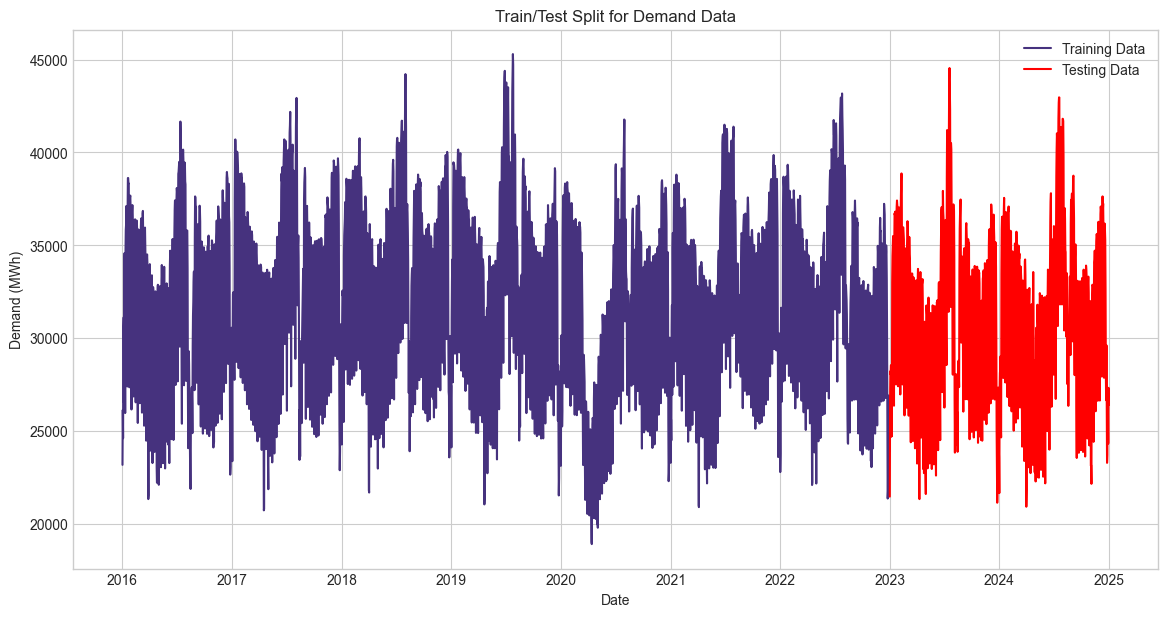

In [45]:
# Prepare train/test split
train_df, test_df = prepare_train_test_split(df)

## Conclusion

This notebook has performed a comprehensive exploratory data analysis of the Italian energy demand data from 2015-2024. Key findings include:

1. The demand data shows strong seasonal patterns, with higher demand in winter and summer months
2. The time series is stationary according to the ADF test but borderline non-stationary according to the KPSS test
3. Month and day of week are important predictors of demand patterns
4. The data shows strong autocorrelation at lags of 1, 7, and multiples of 7 days, indicating weekly patterns
5. Lag features and rolling statistics show high correlation with the target variable, making them valuable for forecasting

The train/test datasets have been saved and are ready for use in modeling:
- Training data: 2015-2022
- Testing data: 2023-2024
